# Data Description

The ventilator data used in this competition was produced using a modified open-source ventilator connected to an artificial bellows test lung via a respiratory circuit. The diagram below illustrates the setup, with the two control inputs highlighted in green and the state variable (airway pressure) to predict in blue. The first control input is a continuous variable from 0 to 100 representing the percentage the inspiratory solenoid valve is open to let air into the lung (i.e., 0 is completely closed and no air is let in and 100 is completely open). The second control input is a binary variable representing whether the exploratory valve is open (1) or closed (0) to let air out.


In this competition, participants are given numerous time series of breaths and will learn to predict the airway pressure in the respiratory circuit during the breath, given the time series of control inputs.


Each time series represents an approximately 3-second breath. The files are organized such that each row is a time step in a breath and gives the two control signals, the resulting airway pressure, and relevant attributes of the lung, described below.



* Files

* train.csv - the training set

* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format


## Columns

**id** - globally-unique time step identifier across an entire file

**breath_id** - globally-unique time step for breaths

**R** - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.

**C** - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.

**time_step** - the actual time stamp.

**u_in** - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.

**u_out** - the control input for the exploratory solenoid valve. Either 0 or 1.

**pressure** - the airway pressure measured in the respiratory circuit, measured in cmH2O.

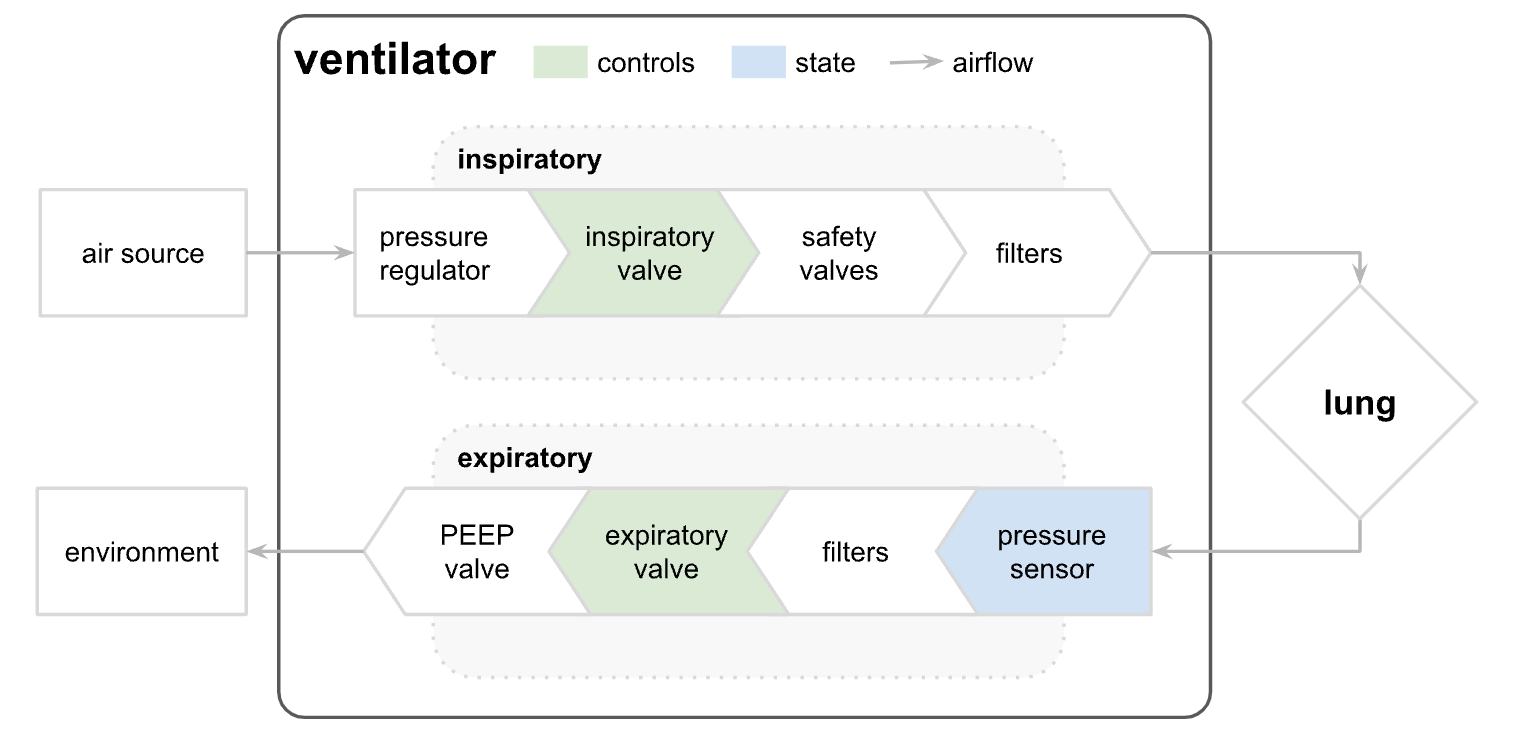

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

# Load Data sets

In [ ]:
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [ ]:
# Data cleaning

train.isna().sum()

In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
test.info()

In [ ]:
train.describe()

In [ ]:
DEBUG = False
if DEBUG:
    train = train[:80*10000]

In [ ]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']

    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df

train = add_features(train)
test = add_features(test)

In [ ]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1)

In [ ]:
RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

In [ ]:
train[0:10]

In [ ]:
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

# Modelling

In [ ]:
EPOCH = 10
BATCH_SIZE = 512

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    kf = KFold(n_splits=2, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        
        # Train and test/Valaidation split 
        
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        # Build Model using Bi LSTM
        
        model = keras.models.Sequential([
            keras.layers.Input(shape=train.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(300, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(250, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(200, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
            keras.layers.Dense(100, activation='relu'),
            keras.layers.Dense(100, activation='relu'),
            keras.layers.Dense(1, activation='linear'),
        ])
        
        model.compile(optimizer="adam", loss="mae")

        scheduler = ExponentialDecay(1e-3, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
        lr = LearningRateScheduler(scheduler, verbose=1)

        model.fit(X_train, y_train, 
                  validation_data=(X_valid, y_valid), 
                  epochs=EPOCH, 
                  batch_size=BATCH_SIZE, 
                  callbacks=[lr]
                 )
        
        test_preds.append(model.predict(test).squeeze().reshape(-1, 1).squeeze())

In [ ]:
submission["pressure"] = sum(test_preds)/5
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()